In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from collections import OrderedDict
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64,64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop((64, 64), padding=None, pad_if_needed=False, fill=0, padding_mode='constant'),
        transforms.RandomResizedCrop((64, 64), scale=(0.07, 1.2), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.RandomRotation((-180, 180)),
        transforms.ToTensor()]),

    'val': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.CenterCrop((64, 64)),
        transforms.ToTensor(),
    ]),
}

data_dir = r'/home/dev2/Sanjana/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import os
os.getcwd()


'/home/dev2/Sanjana'

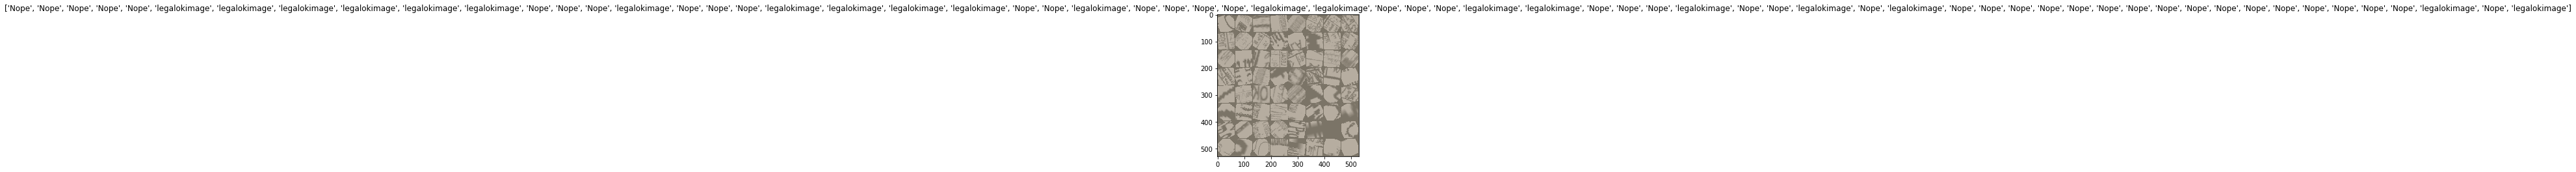

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

 

In [6]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,128)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.4)),
    ('fc2', nn.Linear(128,2)),
    ('output', nn.Softmax(dim=1))
]))
model_ft.fc = fc


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 0.6634 Acc: 0.6111
val Loss: 0.6654 Acc: 0.9200

Epoch 1/199
----------
train Loss: 0.5755 Acc: 0.7817
val Loss: 0.6467 Acc: 0.9600

Epoch 2/199
----------
train Loss: 0.5291 Acc: 0.8016
val Loss: 0.6291 Acc: 0.8800

Epoch 3/199
----------
train Loss: 0.5021 Acc: 0.8532
val Loss: 0.6144 Acc: 0.7600

Epoch 4/199
----------
train Loss: 0.4918 Acc: 0.8413
val Loss: 0.5879 Acc: 0.7600

Epoch 5/199
----------
train Loss: 0.4665 Acc: 0.8651
val Loss: 0.5589 Acc: 0.7600

Epoch 6/199
----------
train Loss: 0.4357 Acc: 0.9167
val Loss: 0.5174 Acc: 1.0000

Epoch 7/199
----------
train Loss: 0.4320 Acc: 0.8929
val Loss: 0.5141 Acc: 1.0000

Epoch 8/199
----------
train Loss: 0.4328 Acc: 0.8968
val Loss: 0.5089 Acc: 1.0000

Epoch 9/199
----------
train Loss: 0.4444 Acc: 0.8690
val Loss: 0.5023 Acc: 1.0000

Epoch 10/199
----------
train Loss: 0.4257 Acc: 0.9008
val Loss: 0.5038 Acc: 1.0000

Epoch 11/199
----------
train Loss: 0.4410 Acc: 0.8889
val Loss: 0.5042 Acc

val Loss: 0.4619 Acc: 0.8800

Epoch 97/199
----------
train Loss: 0.4375 Acc: 0.8770
val Loss: 0.4676 Acc: 0.8800

Epoch 98/199
----------
train Loss: 0.4240 Acc: 0.8889
val Loss: 0.4653 Acc: 0.8800

Epoch 99/199
----------
train Loss: 0.4331 Acc: 0.8770
val Loss: 0.4637 Acc: 0.8800

Epoch 100/199
----------
train Loss: 0.4505 Acc: 0.8571
val Loss: 0.4584 Acc: 0.8800

Epoch 101/199
----------
train Loss: 0.4207 Acc: 0.9087
val Loss: 0.4643 Acc: 0.8800

Epoch 102/199
----------
train Loss: 0.4449 Acc: 0.8690
val Loss: 0.4650 Acc: 0.8800

Epoch 103/199
----------
train Loss: 0.4248 Acc: 0.8968
val Loss: 0.4645 Acc: 0.8800

Epoch 104/199
----------
train Loss: 0.4402 Acc: 0.8810
val Loss: 0.4657 Acc: 0.8800

Epoch 105/199
----------
train Loss: 0.4426 Acc: 0.8770
val Loss: 0.4638 Acc: 0.8800

Epoch 106/199
----------
train Loss: 0.4321 Acc: 0.8730
val Loss: 0.4639 Acc: 0.8800

Epoch 107/199
----------
train Loss: 0.4310 Acc: 0.8810
val Loss: 0.4710 Acc: 0.8800

Epoch 108/199
----------
tr

train Loss: 0.4226 Acc: 0.9048
val Loss: 0.4595 Acc: 0.8800

Epoch 193/199
----------
train Loss: 0.4337 Acc: 0.8929
val Loss: 0.4663 Acc: 0.8800

Epoch 194/199
----------
train Loss: 0.4318 Acc: 0.8810
val Loss: 0.4685 Acc: 0.8800

Epoch 195/199
----------
train Loss: 0.4211 Acc: 0.9048
val Loss: 0.4706 Acc: 0.8800

Epoch 196/199
----------
train Loss: 0.4386 Acc: 0.8849
val Loss: 0.4610 Acc: 0.8800

Epoch 197/199
----------
train Loss: 0.4407 Acc: 0.8810
val Loss: 0.4729 Acc: 0.8800

Epoch 198/199
----------
train Loss: 0.4349 Acc: 0.8849
val Loss: 0.4660 Acc: 0.8800

Epoch 199/199
----------
train Loss: 0.4322 Acc: 0.8889
val Loss: 0.4675 Acc: 0.8800

Training complete in 8m 46s
Best val Acc: 1.000000


In [9]:

torch.save(model_ft,'/home/dev2/Sanjana/resnet_model/resnet_model.h5')

In [10]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

test_transforms = transforms.Compose([transforms.Resize((64, 64)),
transforms.ToTensor()])
# file_path = 'runtime_videos/'
# runtime_path = 'runtime/'
model_path ='/home/dev2/Sanjana/resnet_model/resnet_model.h5'
results_dict = dict()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft1 = torch.load(model_path)
model_ft1 = model_ft1.to(device)
model_ft1.eval()
image = cv2.imread(r'/home/sanjana/dev2/Sanjana/allimagesfromdocs1/image1__0000.png')
#image = cv2.imread(runtime_path+f)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image_tensor = test_transforms(image).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)
output = model_ft1(input)
index = output.data.cpu().numpy().argmax()

AttributeError: 'NoneType' object has no attribute 'to'